In [153]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")
%matplotlib inline
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input"))
#Any results you write to the current directory are saved as output.

In [154]:
test_data = pd.read_csv("./give-me-some-credit/cs-test.csv")
train_data = pd.read_csv("./give-me-some-credit/cs-training.csv")


Unlike our training dataset, our test set the min value of the age feature is 21. The MonthlyIncome and NumberOfDependents feature also has null values and we will handle those accordingly. Ofcourse SeriousDlqin2yrs has 0 values since it is our target class.

**Let's get our hands dirty!**

First, we will look at the distribution of our target class. SeriousDlqin2yrs to have some perspective about the problem.

There is clear problem here, we have an **unbalanced target class!!** we will check the event rate of financial distress (SeriousDlqin2yrs) in our dataset.

In [155]:
class_0 = train_data.SeriousDlqin2yrs.value_counts()[0]
class_1 = train_data.SeriousDlqin2yrs.value_counts()[1]
print("Total number of class_0: {}".format(class_0))
print("Total number of class_1: {}".format(class_1))
print("Event rate: {} %".format(class_1/(class_0+class_1) *100))

Total number of class_0: 139974
Total number of class_1: 10026
Event rate: 6.683999999999999 %


We have an event rate of **6.68%**, consequences of having this kind of target class is most likely that the minority class is being ignored by the algorithm and will predict the new instances to class_0 as it was the safest way to have a great accuracy.
There are guides on how to handle this problem and what I found most useful was the article of Jason Brownlee [here.](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/) This competition uses an evaluation metric AUC so we will work inline with this evaluation metric (i.e using ROC Curve to compare models).
After reading the article I have concluded ways on how to tackle the problem.
1.  Since we have a lot of data, over 100,000 training data set, we will consider using Resampling (Under-sampling to be exact) this strategy will randomly delete some of the instances of the majority class (class_0) to make it balanced. using the [imbalanced-learn module](https://github.com/scikit-learn-contrib/imbalanced-learn)
2. Using penalized models (penalized RF, Logit)
3. Considering ensemble models.


Back to the training set.
age feature has a 0 value in it, so we will locate the entry and impute it with the age median.

In [156]:
train_data.loc[train_data["age"] < 18] #less than legal age

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
65695,65696,0,1.0,0,1,0.436927,6000.0,6,0,2,0,2.0


only one instance, let's impute it right away.

In [157]:
train_data.loc[train_data["age"] == 0, "age"] = train_data.age.median()

We're done with the age feature, now we will go and impute missing values for the MonthlyIncome feature. We will tackle this differently by bracketing ages with the working (18 to 60) and senior (60 and above). First, let's create a temporary dataframes for them and compute for each's median then impute the values accordingly.

In [158]:
age_working = train_data.loc[(train_data["age"] >= 18) & (train_data["age"] < 60)]
age_senior = train_data.loc[(train_data["age"] >= 60)]

age_working_impute = age_working.MonthlyIncome.mean()
age_senior_impute = age_senior.MonthlyIncome.mean()

We will change the monthlyincome data type to int64 then fill those null values with 99999 and impute with the corresponding age's monthlyincome mean.

In [159]:
train_data["MonthlyIncome"] = np.absolute(train_data["MonthlyIncome"])

In [160]:
train_data["MonthlyIncome"] = train_data["MonthlyIncome"].fillna(99999)

In [161]:
train_data["MonthlyIncome"] = train_data["MonthlyIncome"].astype('int64')

In [162]:
train_data.loc[((train_data["age"] >= 18) & (train_data["age"] < 60)) & (train_data["MonthlyIncome"] == 99999),\
               "MonthlyIncome"] = age_working_impute
train_data.loc[(train_data["age"] >= 60) & (train_data["MonthlyIncome"] == 99999), "MonthlyIncome"] = age_senior_impute

/var/folders/42/gncpdw1n5jx_vgps1gq5mzf00000gn/T/ipykernel_62952/2410769817.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6638.484232804233' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_data.loc[((train_data["age"] >= 18) & (train_data["age"] < 60)) & (train_data["MonthlyIncome"] == 99999),\


In [163]:
#check
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         150000 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [164]:
train_data.loc[train_data["MonthlyIncome"] == 99999]

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents


We're done with the Monthly Income, now we will move to the NumberOfDependents feature.

In [165]:
train_data["NumberOfDependents"] = np.absolute(train_data["NumberOfDependents"])
train_data["NumberOfDependents"] = train_data["NumberOfDependents"].fillna(0)
train_data["NumberOfDependents"] = train_data["NumberOfDependents"].astype('int64')

In [166]:
train_data.NumberOfDependents.value_counts()

NumberOfDependents
0     90826
1     26316
2     19522
3      9483
4      2862
5       746
6       158
7        51
8        24
10        5
9         5
20        1
13        1
Name: count, dtype: int64

I decided not to go through each of the numberofdependents feature and impute it by the mode. We will now take a look at the correlation of the features to the target variable.

<Axes: >

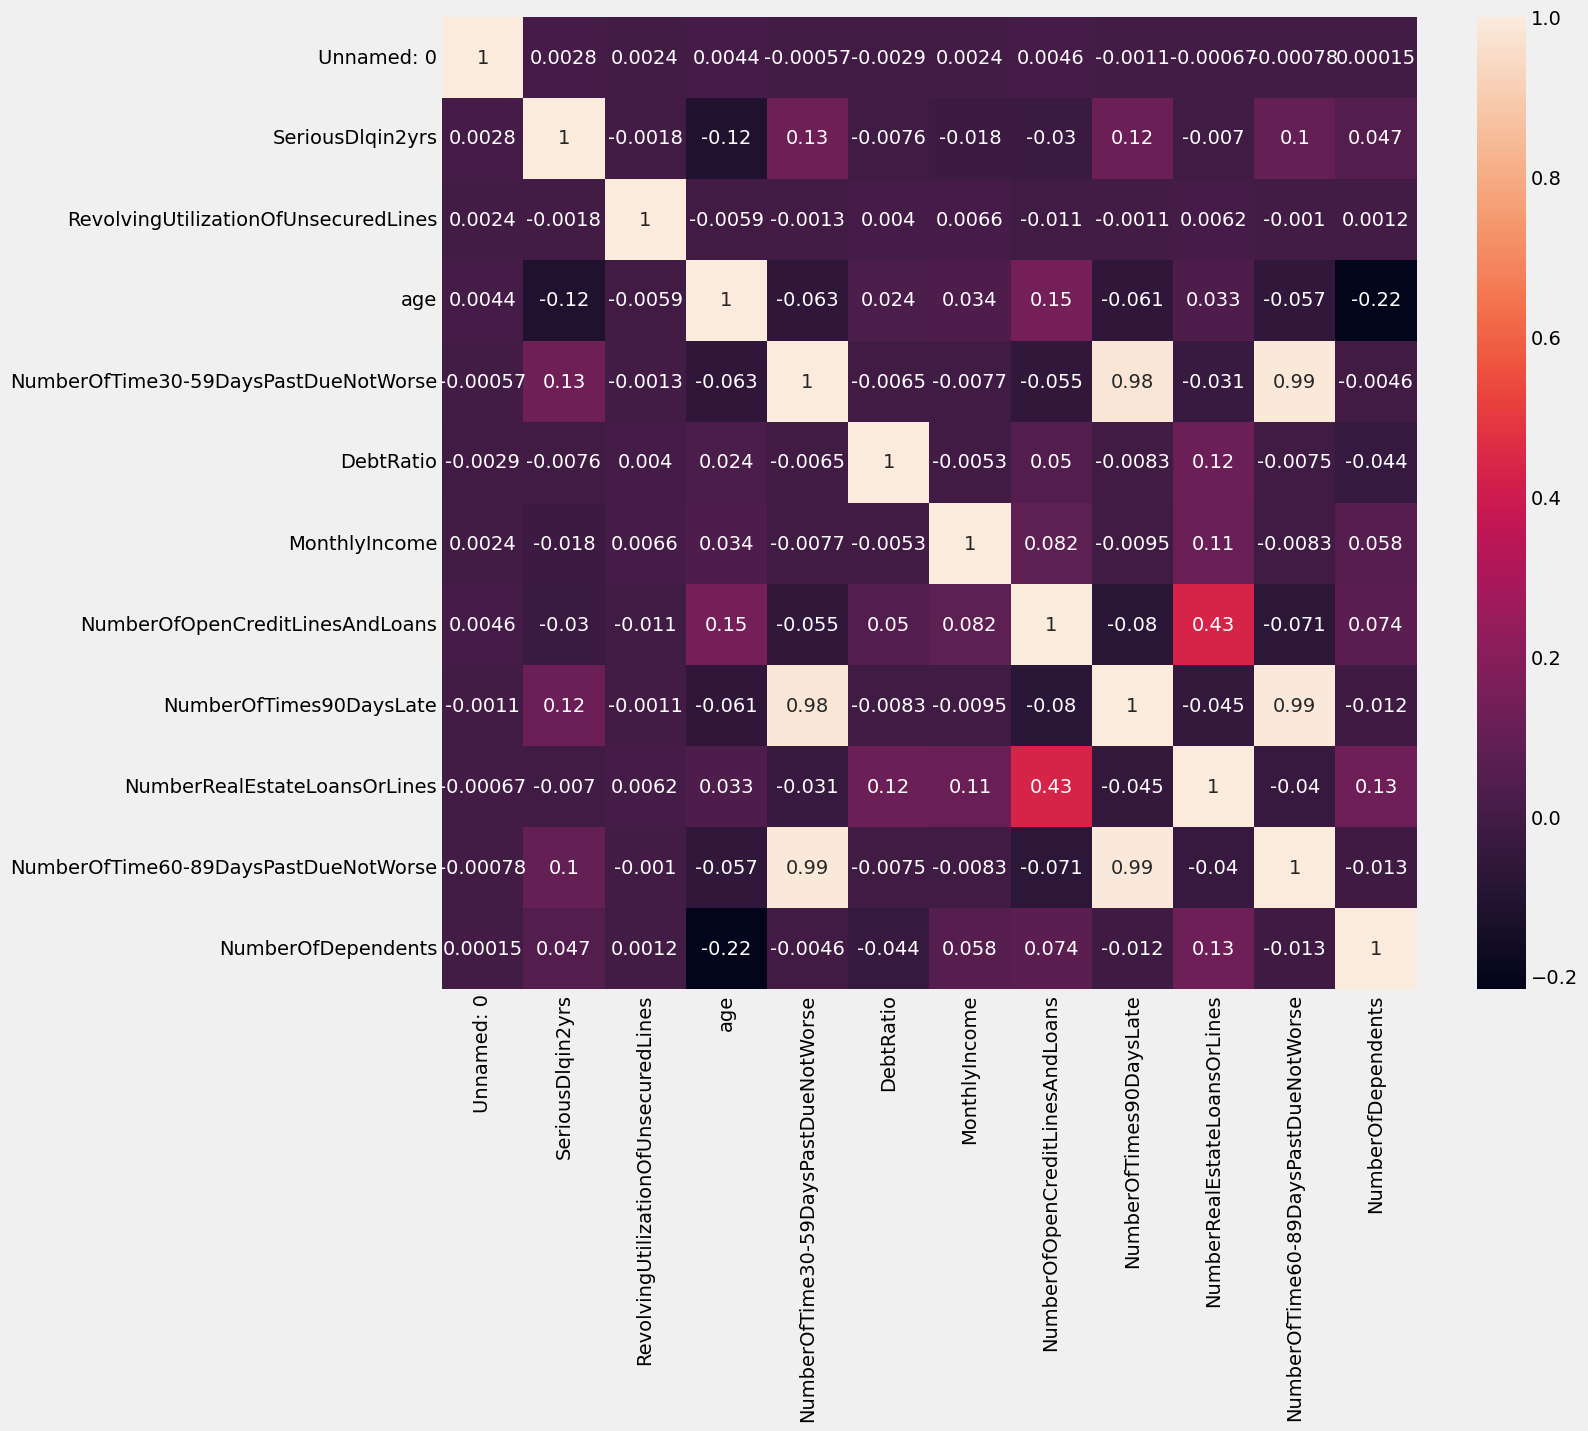

In [167]:
corr = train_data.corr()
plt.figure(figsize=(14,12))
sns.heatmap(corr, annot=True, fmt=".2g")

**Findings**: As expected, the NumberOfTimes90DaysLate, NumberOfTime60-89DaysPastDueNotWorse and NumberOfTime30-59DaysPastDueNotWorse are highly correlated to each other and keeping all those features won't help the prediction power of algorithms(avoiding multicollinearity). I came up with 2 ways to handle this, drop the other 2 features and keep 1 or combine the three features and make a binary feature that classify if a borrower defaulted any loan/credit payment. Also, the NumberOfOpenCreditLinesAndLoans and NumberRealEstateLoansOrLines features are somehow correlated to each other but has different degree of correlation from our target class we can also handle this features the same way as we will handle the pastdue/late features.

We will go with feature engineering the pastdue/late features (because a default is a default!) and credit/loans features but providing a buffer since debts are everywhere!

In [168]:
train_data["CombinedDefaulted"] = (train_data["NumberOfTimes90DaysLate"] + train_data["NumberOfTime60-89DaysPastDueNotWorse"])\
                                        + train_data["NumberOfTime30-59DaysPastDueNotWorse"]

In [169]:
train_data.loc[(train_data["CombinedDefaulted"] >= 1), "CombinedDefaulted"] = 1

In [170]:
train_data["CombinedCreditLoans"] = train_data["NumberOfOpenCreditLinesAndLoans"] + \
                                        train_data["NumberRealEstateLoansOrLines"]

In [171]:
train_data.loc[(train_data["CombinedCreditLoans"] <= 5), "CombinedCreditLoans"] = 0
train_data.loc[(train_data["CombinedCreditLoans"] > 5), "CombinedCreditLoans"] = 1

In [172]:
train_data.CombinedCreditLoans.value_counts()

CombinedCreditLoans
1    111375
0     38625
Name: count, dtype: int64

Next, we will create a binary feature WithDependents which is derived from the NumberOfDependents feature. Also, from the description of the data DebtRatio = Monthly debt payments / monthly gross income. we will extract MonthlyDebtPayments from this formula to get a new feature.

In [173]:
train_data["WithDependents"] = train_data["NumberOfDependents"]
train_data.loc[(train_data["WithDependents"] >= 1), "WithDependents"] = 1

In [174]:
train_data.WithDependents.value_counts()

WithDependents
0    90826
1    59174
Name: count, dtype: int64

In [175]:
train_data["MonthlyDebtPayments"] = train_data["DebtRatio"] * train_data["MonthlyIncome"]
train_data["MonthlyDebtPayments"] = np.absolute(train_data["MonthlyDebtPayments"])
train_data["MonthlyDebtPayments"] = train_data["MonthlyDebtPayments"].astype('int64')

In [176]:
train_data["age"] = train_data["age"].astype('int64')
train_data["MonthlyIncome"] = train_data["MonthlyIncome"].astype('int64')

Also, let's see if we can get a good predictor out of age feature. using senior and working temporary dataframes earlier.

In [177]:
train_data["age_map"] = train_data["age"]
train_data["age_map"] = np.where(
    train_data["age"] >= 60,
    "senior",
    "working"
)

In [178]:
age_dummies = pd.get_dummies(train_data["age_map"], prefix="is")
train_data = pd.concat([train_data, age_dummies], axis=1)
train_data.drop(columns=["age_map"], inplace=True)




Now let's look at the correlation matrix to decide to retain or drop the engineered features (avoiding multicollinearity).

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 18 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         150000 non-null  int64  
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

<Axes: >

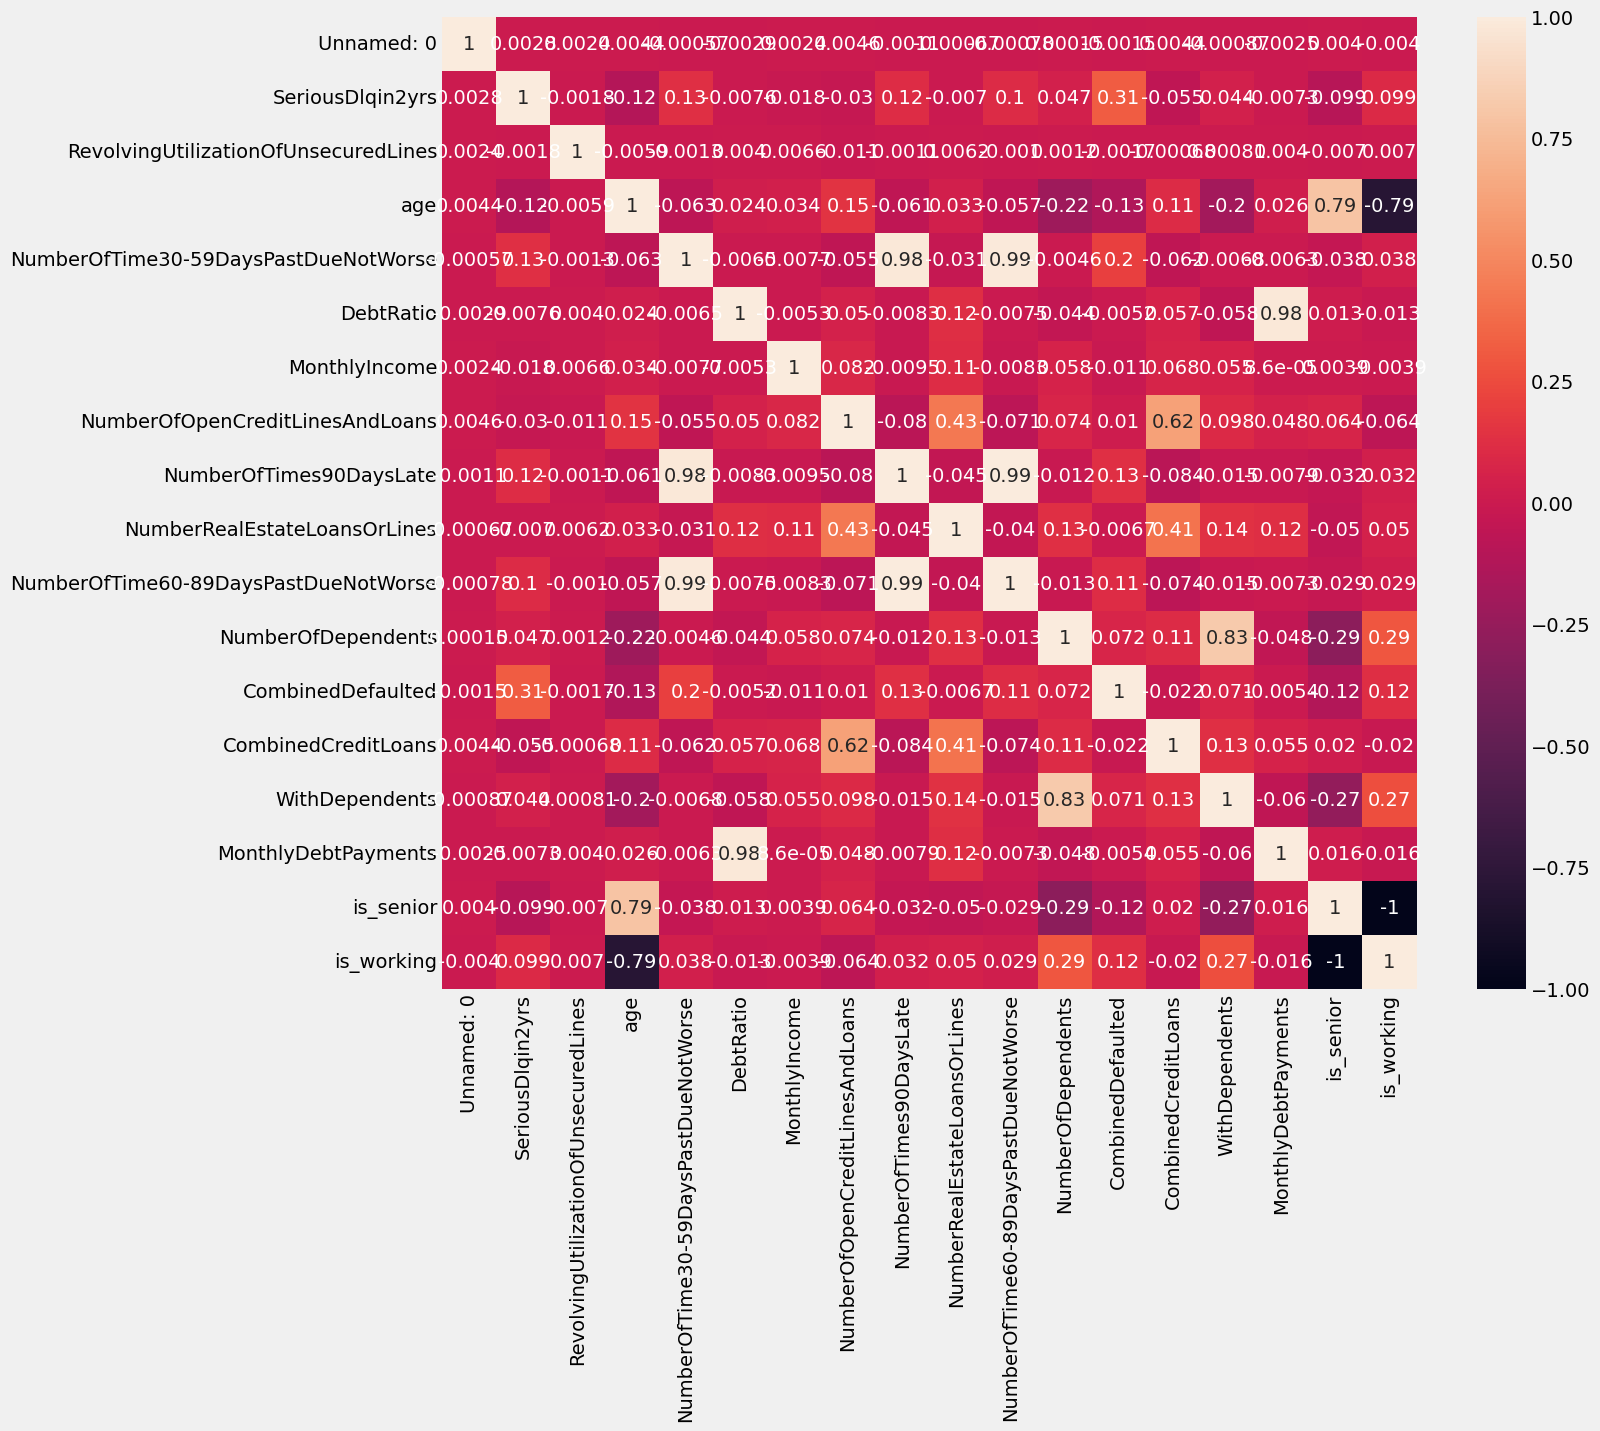

In [179]:
print(train_data.info())
corr = train_data.corr()
plt.figure(figsize=(14,12))
sns.heatmap(corr, annot=True)

Findings: 
* we will retain CombinedDefaulted feature as it clearly a good predictor of our target class than the three features it was derived from.
* we will retain NumberOfTime30-59DaysPastDueNotWorse and drop the other two features derived from CombinedDefaulted as it gives a more meaningful information on our target variable (also, it looks like this is the medium range of time a borrower defaulted a payment)
* we will drop the engineered is_working and is_senior feature since age feature outperforms them.
* we will drop also the WithDependents
* we will retain CombinedCreditLoans also since it outperforms the two features it came from.
* we will drop MonthlyDebtPayments


In [180]:
train_data.columns

Index(['Unnamed: 0', 'SeriousDlqin2yrs',
       'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'CombinedDefaulted', 'CombinedCreditLoans',
       'WithDependents', 'MonthlyDebtPayments', 'is_senior', 'is_working'],
      dtype='object')

In [181]:
train_data.drop(["Unnamed: 0","NumberOfOpenCreditLinesAndLoans",\
                 "NumberOfTimes90DaysLate","NumberRealEstateLoansOrLines","NumberOfTime60-89DaysPastDueNotWorse",\
                 "WithDependents","is_senior","is_working", "MonthlyDebtPayments"], axis=1, inplace=True)

In [182]:
train_data.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfDependents', 'CombinedDefaulted', 'CombinedCreditLoans'],
      dtype='object')

<Axes: >

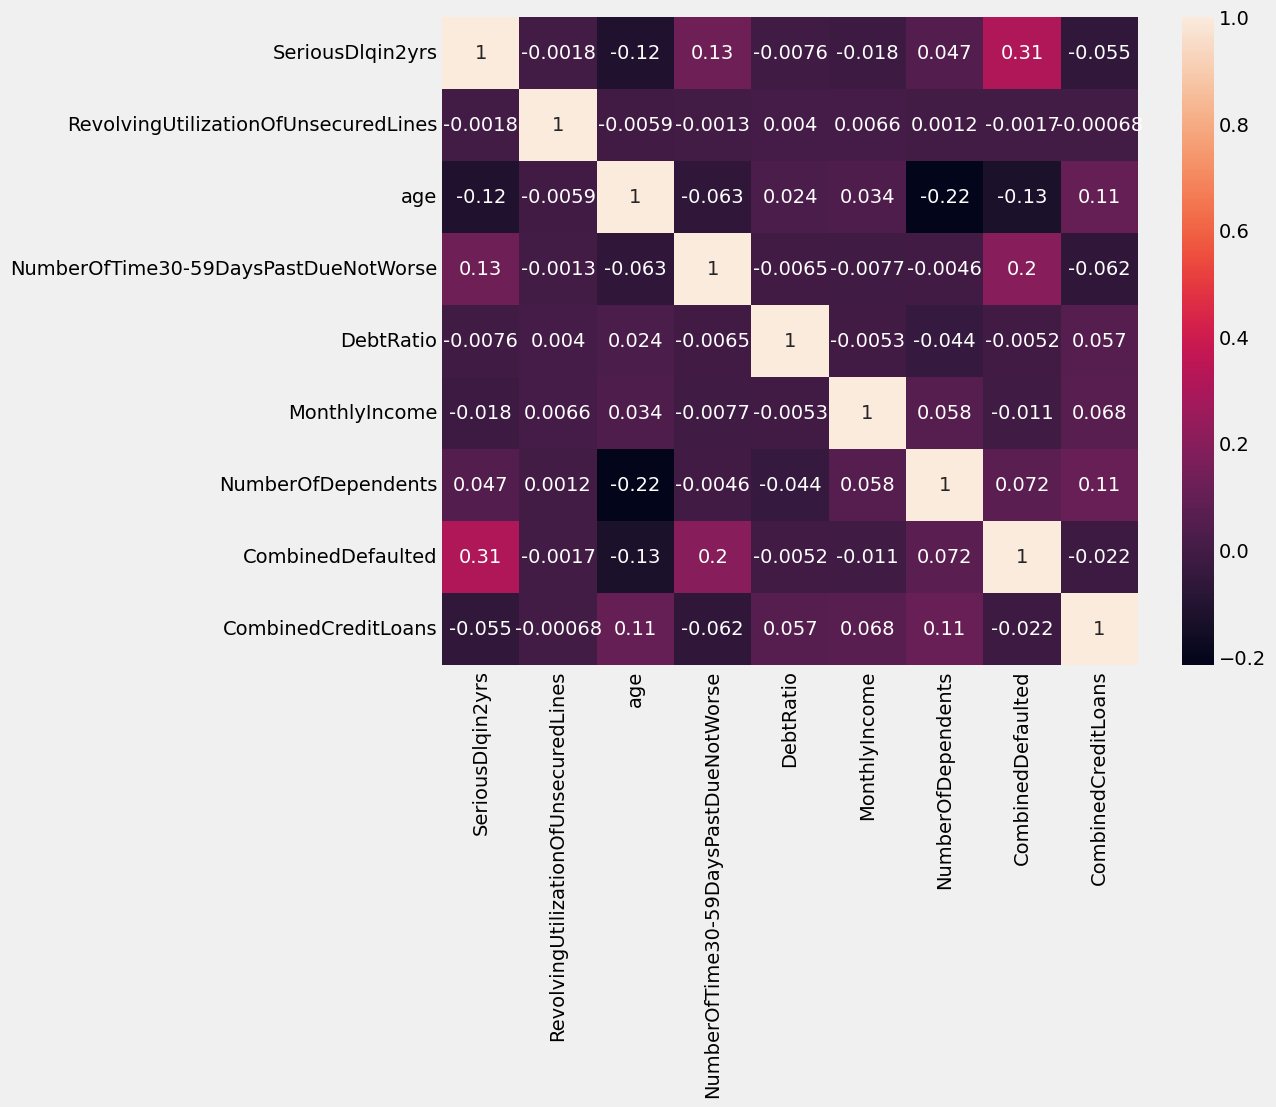

In [183]:
#now let's take a look at the filtered final features to be used in predicting the financial distress for the next two years
corr = train_data.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2g")

Ta-da! we now have clean training dataset. now it's ready to apply algorithms to it but before that, since we have unbalanced dataset we know that this will not generalized well in the test set. So, we need to perform the undersampling or penalized kernels as we shortlisted those strategies earlier.

Now let's also clean the test set! Since we have concluded what features to retain and drop. we will skip some of the process.

In [184]:
def cleaned_dataset(dataset):
    dataset.loc[dataset["age"] <= 18, "age"] = dataset.age.median()
    
    age_working = dataset.loc[(dataset["age"] >= 18) & (dataset["age"] < 60)]
    age_senior = dataset.loc[(dataset["age"] >= 60)]

    age_working_impute = age_working.MonthlyIncome.mean()
    age_senior_impute = age_senior.MonthlyIncome.mean()

    dataset["MonthlyIncome"] = np.absolute(dataset["MonthlyIncome"])
    dataset["MonthlyIncome"] = dataset["MonthlyIncome"].fillna(99999)
    dataset["MonthlyIncome"] = dataset["MonthlyIncome"].astype('int64')

    dataset.loc[((dataset["age"] >= 18) & (dataset["age"] < 60)) & (dataset["MonthlyIncome"] == 99999),\
                   "MonthlyIncome"] = age_working_impute
    dataset.loc[(train_data["age"] >= 60) & (dataset["MonthlyIncome"] == 99999), "MonthlyIncome"] = age_senior_impute
    dataset["NumberOfDependents"] = np.absolute(dataset["NumberOfDependents"])
    dataset["NumberOfDependents"] = dataset["NumberOfDependents"].fillna(0)
    dataset["NumberOfDependents"] = dataset["NumberOfDependents"].astype('int64')

    dataset["CombinedDefaulted"] = (dataset["NumberOfTimes90DaysLate"] + dataset["NumberOfTime60-89DaysPastDueNotWorse"])\
                                            + dataset["NumberOfTime30-59DaysPastDueNotWorse"]

    dataset.loc[(dataset["CombinedDefaulted"] >= 1), "CombinedDefaulted"] = 1

    dataset["CombinedCreditLoans"] = dataset["NumberOfOpenCreditLinesAndLoans"] + \
                                            dataset["NumberRealEstateLoansOrLines"]
    dataset.loc[(dataset["CombinedCreditLoans"] <= 5), "CombinedCreditLoans"] = 0
    dataset.loc[(dataset["CombinedCreditLoans"] > 5), "CombinedCreditLoans"] = 1

    dataset.drop(["Unnamed: 0","NumberOfOpenCreditLinesAndLoans",\
                 "NumberOfTimes90DaysLate","NumberRealEstateLoansOrLines","NumberOfTime60-89DaysPastDueNotWorse"], axis=1, inplace=True)

cleaned_dataset(test_data)

/var/folders/42/gncpdw1n5jx_vgps1gq5mzf00000gn/T/ipykernel_62952/2823152905.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6596.628562971217' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.loc[((dataset["age"] >= 18) & (dataset["age"] < 60)) & (dataset["MonthlyIncome"] == 99999),\


In [185]:
test_data.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfDependents', 'CombinedDefaulted', 'CombinedCreditLoans'],
      dtype='object')

In [186]:
train_data.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfDependents', 'CombinedDefaulted', 'CombinedCreditLoans'],
      dtype='object')

In [187]:
train_data.shape, test_data.shape

((150000, 9), (101503, 9))

In [188]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101503 entries, 0 to 101502
Data columns (total 9 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      0 non-null       float64
 1   RevolvingUtilizationOfUnsecuredLines  101503 non-null  float64
 2   age                                   101503 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  101503 non-null  int64  
 4   DebtRatio                             101503 non-null  float64
 5   MonthlyIncome                         101503 non-null  float64
 6   NumberOfDependents                    101503 non-null  int64  
 7   CombinedDefaulted                     101503 non-null  int64  
 8   CombinedCreditLoans                   101503 non-null  int64  
dtypes: float64(4), int64(5)
memory usage: 7.0 MB


In [189]:
#Let's split our predictors and the target variable in our datasets
X = train_data.drop("SeriousDlqin2yrs", axis=1).copy()
y = train_data.SeriousDlqin2yrs
X.shape, y.shape

((150000, 8), (150000,))

In [190]:
X_test = test_data.drop("SeriousDlqin2yrs", axis=1).copy()
y_test = test_data.SeriousDlqin2yrs
X_test.shape, y_test.shape

((101503, 8), (101503,))

In [205]:
test_data.to_csv("cs-test_clean.csv")
train_data.to_csv("cs-training_clean.csv")

In [ ]:
#let's first try the penalized model Logit by providing the class_weight="balanced" parameter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict #to perform stratified sampling using cv param
from sklearn.metrics import roc_curve, roc_auc_score #AUC score
from sklearn.preprocessing import StandardScaler

X_train, X_val, y_train, y_val = train_test_split(X,y,random_state=42)


In [203]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score

# 1. Modell definieren (Sklearn-API)
# Hinweis: scale_pos_weight hilft bei dem Ungleichgewicht (ca. 1:14)
model_xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,              # Nutzt alle CPU-Kerne
    random_state=42,
    eval_metric='auc',      # Optimiert direkt auf die Kaggle-Metrik
    enable_categorical=True # Falls du Kategorien hättest
)

# 2. Validierung mit Cross-Validation (5-Fold)
# Das zeigt dir, wie stabil dein Modell wirklich ist
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model_xgb, X_train, y_train, cv=cv, scoring='roc_auc')

print(f"Durchschnittlicher AUC-Score: {scores.mean():.4f} (+/- {scores.std():.4f})")

# 3. Finales Training auf allen Trainingsdaten
model_xgb.fit(X_train, y_train)


Durchschnittlicher AUC-Score: 0.8533 (+/- 0.0070)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,'auc'
